# Data Science in Practice - Initial Investigations - 0000


## Early attempt to scrape and explore some of the data available on UKC

Author : Eoghan Cunningham

The following is my initial investigations into the data available on UKC. The main goal of these investigations is to scrape all of the ascents on a route and add to each ascent, some data on the climber in an attempt to quantify their abilities. 

This notebook can serve as an introduction to the project and the format of the data. 

The meat of this notebook is essentially a case study comparing two routes that I have climbed and know to be poorly graded. 

In [14]:
import pandas as pd
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
from bs4 import BeautifulSoup

Below are the necessary links to access route and climber details respectively. They are intended to be formatted with a climber or route ID. Below is an example with my own ID.

In [15]:
route_link = 'https://www.ukclimbing.com/logbook/c.php?i={}'
graphs_link = 'https://www.ukclimbing.com/logbook/showgraph.php?id={}'
my_climber_id = '220094'
british_grades = ['S','HS','VS','HVS','E1','E2','E3','E4','E5','E6','E7','E8']
graphs_link.format(my_climber_id)

'https://www.ukclimbing.com/logbook/showgraph.php?id=220094'

Next we have a function to produce a *pandas dataframe* listing all the ascents of a route given its ID.

In [16]:
def get_route_ascents(route_id) : 
    
    def correct_dates(date) :
        
        # ascents from this year have no year given ie. they take the form DD/MM
        # we use datetime to give the current year (so this should still work in future)
        if date[-1].isalpha() :
            return date+str(datetime.now().year)
        
        # when the month is not given the date is already in the form ??/YYYY.
        else :
            return date
        

    link = route_link.format(route_id)
    source = urllib.request.urlopen(link).read()
    soup = BeautifulSoup(source,'html.parser')
    
    # beautiful soup makes it easy to find the table and store all of it rows
    table = soup.find('div', attrs={'id':'public_logbooks'}).find('table')
    table_rows = table.find_all('tr', attrs={'class':''})
        
    ascents = []
    
    for tr in table_rows:
        td = tr.find_all('td')
        #the climber id is contained in the link to their logbook so we need to store that
        link = tr.find('a').get('href')
        info = [tr.text for tr in td]
        #then we can use a regex to grab it
        climber_id = re.sub(r'.*=', r'', link)
        info.append(climber_id)
        ascents.append(info)
        
        
    # we can convert the ascents data we've just collected into a dataframe
    df = pd.DataFrame(ascents, columns=["name", "date", "style", "comment", "climber_id"])
    
    
    # empty values are represented with a dash, we want to replace these with np.nan
    df['style'] = np.where(df['style']=='-', np.nan, df['style'])
    
    # and drop these null values
    df = df.dropna(subset=['style'])
    
    # finally we can fix the dates
    df['date'] = df["date"].apply(correct_dates)
    
    return df
    

The function below, **add_climber_data**, takes a dataframe containing ascents of a given route and calls a helper function, **get_climber_data**, to retreive and add some info to each ascent. It takes the climber's ID and the year of the ascent and returns information on where they are local to and what grades they climbed that year. 

Ultimately I hope to implement a check to see if we already have the climbers data stored locally. If not, the function will scrape and store it locally. This should reduce the number of requests we have to send to UKC. It will also allow us to change the output of this function and essentially what data we want to consider for each climber/ascent without having to rescrape the data. 

In [17]:
def add_climber_data(route) : 
    
    
    def get_climber_info(climber_id, year) : 
    
        link = graphs_link.format(climber_id)
        source = urllib.request.urlopen(link).read()
        soup = BeautifulSoup(source,'html.parser')

        # the crag (location) that a climber visits most is the first text field found after the divider with the id 'crag' 
        local_to = soup.find("div", {"id": "crag"}).find('a').text

        # average and max grades are stored in the table that is accessed below. 
        # 'gradetype2' is there title for trad climbing and 'British' indicates the british grading system. 
        table = soup.find("div", {"id": "gradetype2"}).find("h5", string = 'British').next_sibling.next_sibling
        stats = table.find_all("tr")
        for row in stats:

            #find the row with the data relevant to the given year.
            if row.text[:4] == year : 

                #and store it in the appropriate variables. 
                max_grade = row.text[-2:]
                avg_grade = row.text[-4:-2]

        return {'climber_id' : climber_id, 'local_to' : local_to,'avg_grade' : avg_grade, 'max_grade' : max_grade}

    climber_data = pd.DataFrame(list(route.apply(lambda row: get_climber_info(row['climber_id'],row['date'][-4:]), axis=1)))

    return pd.concat([route.reset_index() , climber_data.drop(['climber_id'], axis = 1)], axis=1)


# Case Study - Comparing Ascents.
## Heres a quick example using a classic local route "THE SHIELD - E2". 

In [18]:
the_shield = get_route_ascents('42489')

In [19]:
the_shield.sample(10)

,name,date,style,comment,climber_id
1,BrendanR,6 May2019,Lead rpt,with Big Huge Massive Neil,186094
55,davkeo,"1 Aug, 2015",Lead rpt,Clean at last. Felt solid.with Ambrose Flynn,187253
0,markflanagan,6 May2019,Lead rpt,,167496
39,sarpedon,"25 Jun, 2017",Lead dog,,126301
79,Bri.Moo,"25 May, 2012",Lead RP,Third go on it? Great route.,116404
83,zhwang,"??, 2011",Lead RP,,96059
42,hamer89,"13 May, 2017",Lead G/U,First route at Dalkey,92409
40,Barrie Schofield II,"22 May, 2017",Lead O/S,,197486
85,Niall Ewen,"26 Jun, 2010",Lead dog,,123521
32,Theo Mossop,"18 Jul, 2017",Lead RP,EZPZwith Finn McWilliams,202096


Above we can see a random sample of the ascents of **The Shield**

We can add more data to our table though...

In [20]:
the_shield = add_climber_data(the_shield)
the_shield.sample(10)

,index,name,date,style,comment,climber_id,avg_grade,local_to,max_grade
77,83,zhwang,"??, 2011",Lead RP,,96059,VS,Dalkey quarry,E6
88,96,Claire Hardy,"??, 2008",TR,,101185,E2,Dalkey quarry,E5
21,21,James Mulhall,"7 Jun, 2018",Lead rpt,"Finally got it clean, felt pretty solid jammin...",220905,VS,Dalkey quarry,E3
4,4,scottw,28 Mar2019,Lead RP,,214707,VS,Dalkey quarry,E2
64,70,Betsy,"5 Jul, 2013",Lead,Did the E1 version using the fault line to the...,134168,VS,Dalkey quarry,E2
78,84,SeanT,"1 Sep, 2010",Lead dnf,with Tom Bannon,93552,VS,Dalkey quarry,E2
29,30,Eric Walshe,"?Mar, 2018",Lead dnf,with Fionnuala,226367,VS,Dalkey quarry,E3
8,8,Chaelcifer,28 Feb2019,Lead dog,with Wiki,250707,VS,"Ailladie (Burren, Co. Clare)",E3
16,16,tim91,"20 Jun, 2018",Lead,First E grade! Super psyched to get to the top...,130556,HS,Hen Mountain,E2
39,40,Barrie Schofield II,"22 May, 2017",Lead O/S,,197486,VS,Stanage Popular,E4


## Similarly we can get data on another route with the same grade - 'OVERDUE - E2'

In [21]:
overdue = get_route_ascents('86807')

In [22]:
overdue = add_climber_data(overdue)
overdue

,index,name,date,style,comment,climber_id,avg_grade,local_to,max_grade
0,0,Edpepper,5 May2019,Lead O/S,,219437,E2,Blacknor Central,E2
1,1,Lorcan Quinn,5 May2019,Lead O/S,1st E2,230992,E2,Chulilla,E2
2,2,alexhazael,23 Apr2019,2nd dog,Great climbing after the reachy cruxwith Aaron,249950,VS,Dalkey quarry,E1
3,3,AaronBCaldwell,23 Apr2019,Lead O/S,Lovely routewith alexhazael,249970,E2,Frontales,E4
4,4,Ian Lemon,7 Apr2019,Lead O/S,First e2! Would still say it's at the lower en...,234790,E2,Gola Island,E2
5,5,MichealMurphy,7 Apr2019,Lead RP,"Dogged it the day before, figured out the shor...",204773,VS,Hen Mountain,E2
6,6,Eric Walshe,29 Mar2019,2nd rpt,with Adam Timmons,226367,VS,Dalkey quarry,E2
7,7,Adam Timmons,29 Mar2019,Lead β,"Reached through the crux fairly easily, pretty...",226818,VS,Dalkey quarry,E2
8,8,Eric Walshe,20 Mar2019,Lead O/S,Fairly reachy at the crux but bomber gear all ...,226367,VS,Dalkey quarry,E2
9,9,George Ponsonby,"27 Oct, 2018",Lead O/S,Snowstorm!,213309,E3,Dalkey quarry,E6


We want to compare the ascents on these two routes. Despite sharing the same grade, I believe "The Sheild" to be considerably more difficult than "Overdue".

In [23]:
data = {'S' : 0, 'HS' : 0, 'VS' : 0, 'HVS' : 0, 'E1' : 0,'E2' : 0,\
        'E3' : 0, 'E4' : 0, 'E5' : 0, 'E6' : 0, 'E7' : 0}
grades = pd.Series(data)

The 'style' of an ascents gives us information on the how successful the ascent was.

Most notably, 'Lead O/S' implies the climber was successful on their first attempt with no prior knowledge of the route, while 'Lead dog' or 'Lead dnf' are for climbers who were unsuccesful. Redpoint ascents are successful attempts that were not the climbers first attempt and are marked 'Lead RP'

In [24]:
the_shield.groupby(['style','max_grade'])['style'].agg('count')

style     max_grade
2nd       E2           3
          E3           1
          E4           1
          E6           1
2nd O/S   E2           1
          E4           1
2nd dnf   E2           1
2nd dog   E2           3
          E3           2
          VS           1
Lead      E2           7
          E3           3
          E4           1
Lead G/U  E2           1
          E6           1
Lead O/S  E4           2
          E5           1
          E6           1
          E8           1
Lead RP   E2           8
          E3           3
          E4           3
          E5           1
          E6           1
Lead dnf  E1           1
          E2           1
          E3           3
          E6           1
Lead dog  E1           1
          E2           8
          E3           6
          E4           2
          E7           1
Lead rpt  E2           1
          E3           7
          E4           2
          E5           1
Lead β    E2           1
          E8           1
TR   

In [25]:
grade_index = ['S','HS','VS','HVS','E1','E2','E3','E4','E5','E6','E7','E8']

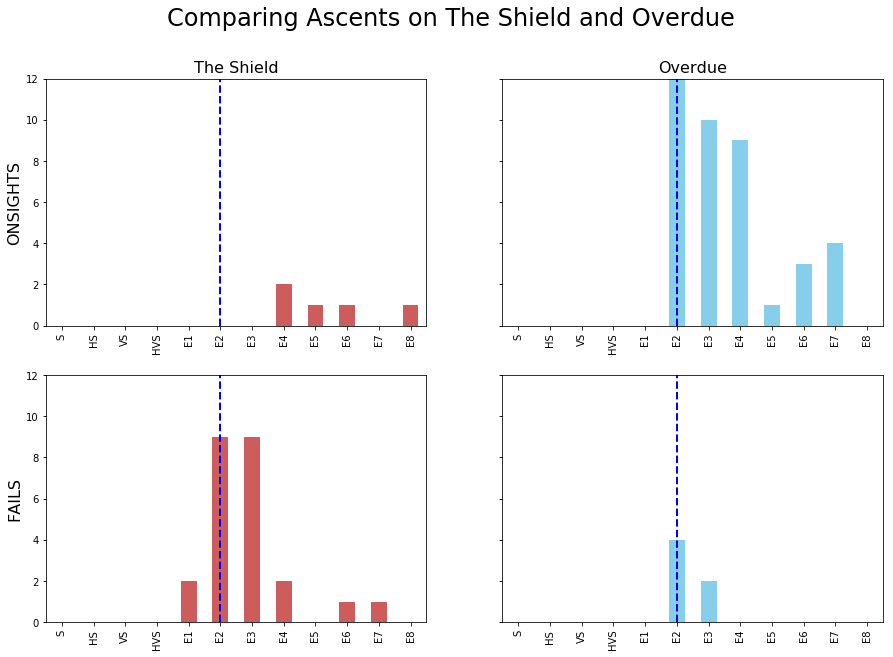

In [26]:
shield_ascents = the_shield.groupby(['style','max_grade'])['style'].agg('count')
overdue_ascents = overdue.groupby(['style','max_grade'])['style'].agg('count')

shield_onsights = grades.add(shield_ascents['Lead O/S'],fill_value = 0)
shield_unsuccessful = grades.add(shield_ascents['Lead dog'],fill_value = 0).add(shield_ascents['Lead dnf'],fill_value = 0)

overdue_onsights = grades.add(overdue_ascents['Lead O/S'],fill_value = 0)
overdue_unsuccessful = grades.add(overdue_ascents['Lead dog'],fill_value = 0).add(overdue_ascents['Lead dnf'],fill_value = 0)

f, axarr = plt.subplots(2, 2,figsize=(15, 10), sharey = True)
plt.ylim([0, 12])
shield_onsights.reindex(grade_index).plot.bar(color = 'IndianRed',ax=axarr[0,0]).axvline(5, color='b', linestyle='--', linewidth=2)
overdue_onsights.reindex(grade_index).plot.bar(color = 'SkyBlue',ax=axarr[0,1]).axvline(5, color='b', linestyle='--', linewidth=2)
shield_unsuccessful.reindex(grade_index).plot.bar(color = 'IndianRed',ax=axarr[1,0]).axvline(5, color='b', linestyle='--', linewidth=2)
overdue_unsuccessful.reindex(grade_index).plot.bar(color = 'SkyBlue',ax=axarr[1,1]).axvline(5, color='b', linestyle='--', linewidth=2)

axarr[0,0].set_title('The Shield',fontsize=16)
axarr[0,1].set_title('Overdue',fontsize=16)

axarr[0,0].set_ylabel('ONSIGHTS',fontsize=16)
axarr[1,0].set_ylabel('FAILS',fontsize=16)


f.suptitle('Comparing Ascents on The Shield and Overdue', fontsize=24)

plt.show()

It is evident from the plots above that by considering the success and abilities of the climbers attempting the above routes, we can tell that despite the routes sharing the same grade, 'The Shield' appears seems to be considerably harder than 'Overdue'. That is to say that far fewer climbers are successful on the 'The Shield' on their first attempt than on 'Overdue'. Only very good climbers (those with a high max grade) are able to onsight 'The Shield'. In fact the climbers who fall off 'The Shield' seem very similar to those who are able to onsight 'Overdue'.

I know the Shield to be harder than Overdue as I have climbed both routes. What the plots above show is that this is evident in our data, (if we know where to look). The Shield is harder than the grade suggests. This is known as 'a sandbag'. I would conisder the above plots decent grounds to suggest that we can spot sandbags from the data that we are able to piece together. 